In [529]:
import assembly as assembly
import time as time
import numpy as np
import matplotlib.pyplot as plt
import os
import functools
from scipy.stats import pearsonr
from imports import *  # shortcut for standard imports

%matplotlib inline

In [530]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Read spiketrains

In [575]:
s1 = "008229_hippoSIT_2022-05-17_21-44-43"
s1_units_all = {  # take 0.5 time step
    1: [2, 4, 8, 10, 15, 18, 19, 22, 26, 28],
    3: [3, 8, 12, 13, 14],
    4: [2, 4, 8, 16],
    5: [7, 14, 15, 16, 18, 20, 25, 28, 29, 31],
    6: [2, 4, 5, 7, 18, 19, 20, 21],
    7: [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19],
    8: [2, 3, 4, 5, 8, 10, 11, 12, 13, 15, 16, 17],
}

s2 = "008229_hippoSIT_2022-05-16_20-36-44"
s2_units_all = {  # take 0.5 time step
    1: [7, 8, 10, 23, 24, 33, 36, 37, 38],
    2: [9, 15],
    5: [13],
    6: [5, 10, 18, 23, 25, 26],
    7: [2, 3, 4, 5, 6, 7, 9, 12, 14, 15, 17, 18],
    8: [3, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19],
}

s3 = "008229_hippoSIT_2022-05-20_15-54-39"
s3_units_all = {
    1: [10, 13, 15],
    2: [4, 6, 8, 9, 10, 11],
    3: [3, 5, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21],
    4: [3, 5, 8, 12, 13, 14],
    5: [5, 6],
    6: [3, 5, 7, 8, 9, 11, 14],  # 7, 11 - food
    7: [2, 3, 4, 7, 8, 9],
    8: [3, 7, 11, 12],
}
s3_units_no_speed = {
    1: [10, 13],
    2: [4, 6, 8, 9],
    3: [3, 5, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21],
    4: [3, 5, 8, 12, 13, 14],
    5: [5, 6],
    6: [3, 7, 8, 9, 11],  # 7, 11 - food
    7: [7, 8, 9],
    8: [3, 7, 11],
}

s4 = "008229_hippoSIT_2022-05-18_14-36-18"
s4_units_all = {
    1: [2, 4, 12, 17, 18, 20, 24, 26],  # 16, 21 food
    2: [2],
    3: [2, 6, 7, 8],
    4: [10, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    5: [2, 3, 5, 7, 8, 11, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27],
    6: [2, 9, 14, 15, 16, 17, 18, 19, 20],
    7: [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16],  # could be spatial / ego
    8: [2, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 16, 17, 18],
}
s4_units_no_speed = {  # take 0.1 time step
    1: [2, 4, 12, 17, 18, 20, 24, 26],  # 16, 21 food
    2: [2],
    3: [6, 7, 8],
    4: [13, 14, 15, 16, 17, 20, 21],
    5: [2, 3, 5, 7, 8, 11, 15, 16, 18, 19, 21, 22, 24, 25],
    6: [2, 9, 14, 15, 16, 17, 18, 19],
    7: [3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16],  # could be spatial / ego
    8: [2, 3, 5, 8, 10, 12, 13, 14, 15, 16, 17, 18],
}

s5 = "008229_hippoSIT_2022-05-13_15-17-12"
s5_units_all = {
    7: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    8: [4, 7, 10, 11, 12],
}

In [532]:
source  = '/home/sobolev/nevermind/Andrey/data'
#source  = '/home/andrey/projects/data/'
session = s2
units_all = s2_units_all

animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')

In [533]:
spike_times = []  # list of spiketrains
unit_names  = []

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    all_unit_names = [x for x in f['units']]
    
    for unit_name in all_unit_names:
        electrode, unit = unit_name.split('-')
        if not int(electrode) in units_all or not int(unit) in units_all[int(electrode)]:
            continue
            
        s_times = np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
        spike_times.append(s_times)
        unit_names.append(unit_name)

print("Extracted %s spiketrains" % len(spike_times))

Extracted 66 spiketrains


## Compute activation matrix

In [534]:
window  = 0.23  # in seconds
t_start = round(tl[0][0])
t_end   = round(tl[-1][0])

bins = np.linspace(t_start, t_end, int((t_end - t_start)/window) + 1)
actmat = np.zeros((len(spike_times), len(bins) - 1))

for i, spiketrain in enumerate(spike_times):
    actmat[i], _ = np.histogram(spiketrain, bins=bins)

Text(0, 0.5, 'Neuron #')

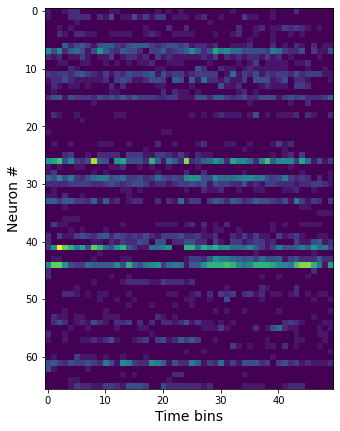

In [535]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(actmat[:,0:50]) # shows first 30 neurons / 50 time bins of spiking
ax.set_xlabel("Time bins", fontsize=14)
ax.set_ylabel("Neuron #", fontsize=14)

In [375]:
# patching if needed
idx = unit_names.index('3-20')

i_rate = actmat[idx]

width = 5000  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)

i_rate_lf = np.convolve(i_rate, kernel, 'same') / kernel.sum()
i_rate_lf[:int(width/2)]  = i_rate_lf[int(width/2) + 1]
i_rate_lf[-int(width/2):] = i_rate_lf[-int(width/2) - 1]

actmat[idx] = i_rate/i_rate_lf

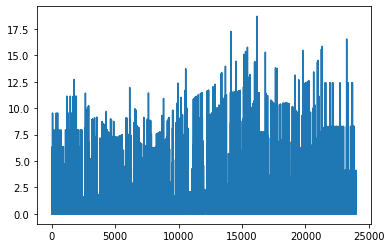

In [376]:
plt.plot(actmat[idx])

## Compute assemblies

In [536]:
# using Marcenko-Pastur function as null distribution
t0 = time.time()
patterns, significance, zactmat = assembly.runPatterns(actmat, nullhyp='mp')
tf = np.round(1000*(time.time() - t0)) / 1000

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [29]:
# using simple bin shuffling for computing null distribution
#nshu = 1000 # defines number of controls to run (i.e., number of elements in null hypothesis distribution)
#percentile = 99.5 # defines which percentile of control distribution will be used as significance threshold
#t0 = time.time()
#patterns, significance, zactmat = assembly.runPatterns(actmat,nullhyp='bin',nshu=nshu,percentile=percentile)
#tf = np.round(1000*(time.time()-t0))/1000

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [43]:
# using circular shuffling for computing null distribution (MUST USE IT IF YOU HAVE STRONG AUTOCORRELATIONS)
#nshu = 1000 # defines number of controls to run (i.e., number of elements in null hypothesis distribution)
#percentile = 99.5 # defines which percentile of control distribution will be used as significance threshold
#t0 = time.time()
#patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='circ',nshu=nshu,percentile=percentile)
#tf = np.round(1000*(time.time()-t0))/1000

/home/andrey/projects/pySIT/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [276]:
len(patterns)

13

## Plot patterns

Text(0.5, 0, 'Neuron #')

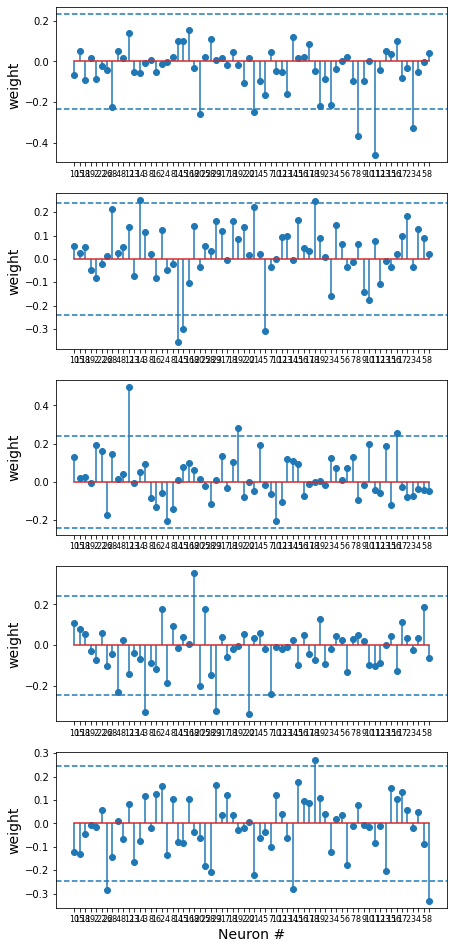

In [544]:
#painted = ['3-20', '3-17', '4-8', '4-12']
#painted = ['8-17', '8-18', '7-8', '6-14']
#painted = ['8-18', '8-17']
#idxs_sel = [unit_names.index(x) for x in painted]

fig = plt.figure(figsize=(7, 20))
x_ticks = [x.split('-')[1] for x in unit_names]

for pi, pattern in enumerate(patterns[:5]):
    std = np.std(pattern)
    
    ax = fig.add_subplot(int(np.ceil(len(patterns)/2)), 1, 1+pi)
    ax.stem(pattern)
    #ax.stem(idxs_sel, pattern[idxs_sel], linefmt='red', markerfmt='D')
    #ax.set_xlabel('neuron #')
    ax.set_ylabel('weight', fontsize=14)
    ax.set_xticks(np.arange(len(spike_times)))
    ax.set_xticklabels(x_ticks, fontsize=8)
    ax.axhline( 2*std, ls='--')
    ax.axhline(-2*std, ls='--')
        
ax.set_xlabel('Neuron #', fontsize=14)
#plt.suptitle('Elapsed time: '+str(tf)+' seconds')
#fig.tight_layout()

## Select assemblies with weights > 2*STD

In [539]:
selected = {}
for i, pattern in enumerate(patterns):
    idxs_pos = np.where(pattern >  1.8 * np.std(pattern))[0]
    idxs_neg = np.where(pattern < -1.8 * np.std(pattern))[0]
    if len(idxs_pos) < 2 and len(idxs_neg) < 2:
        continue
    
    idxs = idxs_pos if len(idxs_pos) >= len(idxs_neg) else idxs_neg
    assembly_weights = np.abs(np.round(pattern[idxs], 3))
    assembly_names = [unit_names[i] for i in idxs]
    
    selected[i] = dict(zip(assembly_names, assembly_weights))

In [540]:
#selected[11] = {'3-17': 0.257, '3-20': 0.346}

In [541]:
selected

{0: {'1-28': 0.224,
  '5-20': 0.256,
  '6-21': 0.25,
  '7-19': 0.217,
  '7-3': 0.216,
  '7-8': 0.365,
  '8-11': 0.46,
  '8-3': 0.328},
 1: {'3-14': 0.25, '6-21': 0.224, '7-18': 0.249},
 2: {'3-12': 0.498, '6-19': 0.283, '8-16': 0.255},
 3: {'1-4': 0.23, '3-3': 0.326, '5-29': 0.323, '6-20': 0.338, '6-7': 0.24},
 4: {'1-26': 0.287, '6-21': 0.221, '7-14': 0.281, '8-8': 0.331},
 5: {'1-19': 0.499, '1-8': 0.509, '3-8': 0.31, '6-7': 0.24},
 6: {'1-28': 0.229, '5-7': 0.283, '6-18': 0.31, '7-14': 0.25, '7-6': 0.279},
 7: {'7-12': 0.393, '8-16': 0.242, '8-4': 0.447},
 8: {'6-4': 0.235, '7-3': 0.234},
 9: {'1-15': 0.231, '3-13': 0.245, '4-16': 0.215, '6-19': 0.217},
 10: {'7-4': 0.267, '7-5': 0.478, '8-15': 0.364},
 11: {'1-4': 0.261, '6-19': 0.34, '7-13': 0.223, '7-17': 0.426}}

In [411]:
# compute assembly averages
assembly_activity = {}
for idx, ass_params in selected.items():
    i_rates, weights = [], []
    for unit_name, weight in ass_params.items():
        weights.append(weight)
        with h5py.File(h5name, 'r') as f:
            i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
            
            if unit_name == '3-20':
                width = 50000  # 100 points ~= 1 sec with at 100Hz
                kernel = signal.gaussian(width, std=(width) / 7.2)

                i_rate_lf = np.convolve(i_rate, kernel, 'same') / kernel.sum()
                i_rate_lf[:int(width/2)]  = i_rate_lf[int(width/2) + 1]
                i_rate_lf[-int(width/2):] = i_rate_lf[-int(width/2) - 1]
                i_rate = i_rate/i_rate_lf
            
            i_rates.append(i_rate)            
        
    weighted_avg = np.zeros(len(i_rates[0]))
    for i in range(len(i_rates)):
        weighted_avg += weights[i] * i_rates[i]
        
    assembly_activity[idx] = weighted_avg

In [412]:
#save assemblies to H5
with h5py.File(h5name, 'a') as f:
    if 'assemblies' in f:  # overwrite mode
        del f['assemblies']

    ass_g = f.create_group('assemblies')

    for i, key in enumerate(selected.keys()):
        ds = ass_g.create_dataset(str(i+1), data=assembly_activity[key])
        ds.attrs['weights'] = json.dumps(selected[key])

## Plot single assembly firing

In [605]:
source  = '/home/sobolev/nevermind/Andrey/data'
#source  = '/home/andrey/projects/data/'
session = '008229_hippoSIT_2022-05-17_21-44-43'
#session = '008229_hippoSIT_2022-05-16_20-36-44'
#session = '008229_hippoSIT_2022-05-20_15-54-39'
#session = '008229_hippoSIT_2022-05-18_14-36-18'

animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')

In [606]:
assembly_activity = {}
selected = {}
with h5py.File(h5name, 'r') as f:
    for ass_id in f['assemblies']:
        assembly_activity[int(ass_id)] = np.array(f['assemblies'][ass_id])
        selected[int(ass_id)] = json.loads(f['assemblies'][ass_id].attrs['weights'])

In [607]:
selected

{1: {'3-12': 0.425, '6-19': 0.247, '6-4': 0.253, '8-10': 0.25, '8-16': 0.287},
 10: {'1-4': 0.259, '6-19': 0.347, '7-17': 0.432},
 11: {'5-14': 0.344, '5-15': 0.295, '6-5': 0.306},
 2: {'3-12': 0.278, '7-2': 0.288, '8-12': 0.33},
 3: {'3-3': 0.306, '5-29': 0.342, '6-20': 0.358},
 4: {'4-16': 0.265, '5-7': 0.252, '6-18': 0.303},
 5: {'1-8': 0.263, '7-5': 0.392, '8-15': 0.361},
 6: {'1-26': 0.28, '7-14': 0.276, '8-8': 0.336},
 7: {'5-20': 0.241, '6-21': 0.25, '7-8': 0.357, '8-11': 0.453, '8-3': 0.344},
 8: {'5-31': 0.432, '7-19': 0.455},
 9: {'7-12': 0.404, '8-4': 0.44}}

In [608]:
ass_idx = 6

i_rates, s_times = [], []
for unit_name, weight in selected[ass_idx].items():
    with h5py.File(h5name, 'r') as f:
        i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
        s_tms = np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
        
    i_rates.append(i_rate)
    s_times.append(s_tms)
    
weighted_avg = assembly_activity[ass_idx]

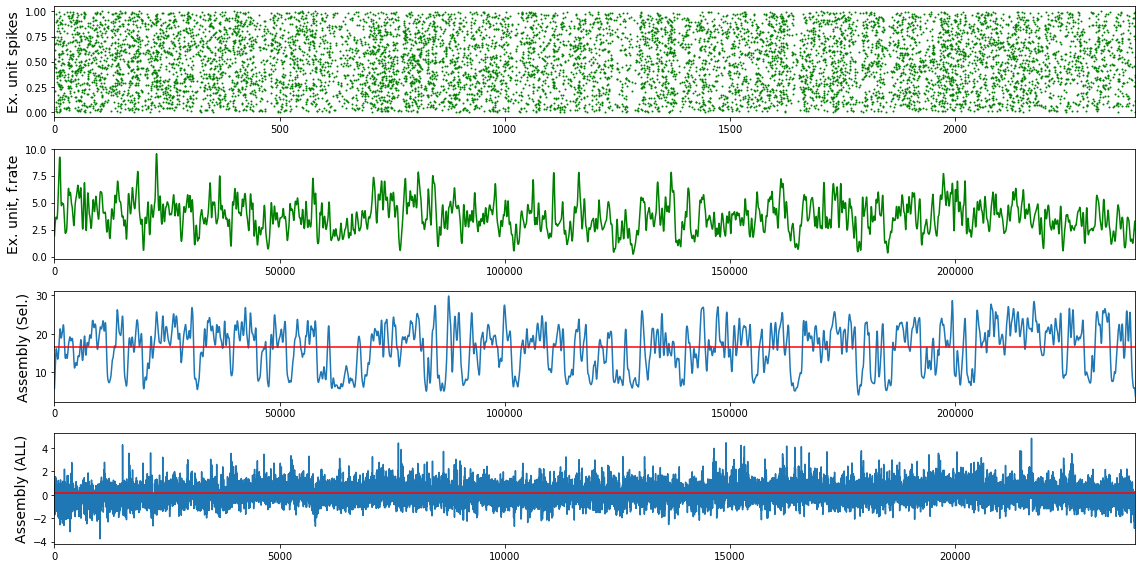

In [479]:
fig = plt.figure(figsize=(16, 8))

idx = 1
ax = fig.add_subplot(411)
ax.scatter(s_times[idx], np.random.rand(len(s_times[idx])), s=1, color='green')
ax.set_xlim(tl[0][0], tl[-1][0])
ax.set_ylabel('Ex. unit spikes', fontsize=14)

ax = fig.add_subplot(412)
ax.plot(i_rates[idx], color='green')
ax.set_xlim(0, len(i_rates[idx]))
ax.set_ylabel('Ex. unit, f.rate', fontsize=14)

ax = fig.add_subplot(413)
ax.plot(weighted_avg)
ax.set_xlim(0, len(weighted_avg))
ax.set_ylabel('Assembly (Sel.)', fontsize=14)
ax.axhline(np.mean(weighted_avg), color='red')

f_rate = np.dot(actmat.T, patterns[ass_idx])
ax = fig.add_subplot(414)
ax.plot(np.dot(actmat.T, patterns[ass_idx]))
ax.set_xlim(0, len(f_rate))
ax.set_ylabel('Assembly (ALL)', fontsize=14)
ax.axhline(np.mean(f_rate), color='red')

fig.tight_layout()

Text(0.5, 1.0, '2022-05-18_14-36-18')

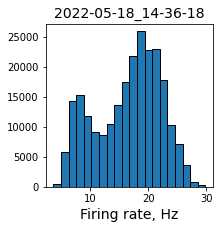

In [603]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.hist(assembly_activity[ass_idx], bins=20, edgecolor='black')
#ax.axvline(thresh, color='orange', ls='--')
ax.set_xlabel('Firing rate, Hz', fontsize=14)
ax.set_title(session[-19:], fontsize=14)

## Units intersection

In [474]:
all_units = sorted(list(set([unit for assembly in selected.values() for unit in assembly])))
ass_matrix = np.zeros((len(selected), len(all_units)))

for i, assembly in selected.items():
    for unit, weight in assembly.items():
        idx = all_units.index(unit)
        
        ass_matrix[i-1][idx] = weight

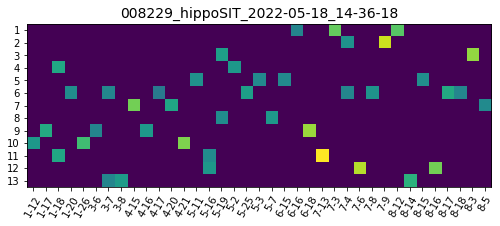

In [475]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))
ax.imshow(ass_matrix)
ax.set_xticks(range(len(all_units)))
_ = ax.set_xticklabels(all_units, rotation=60)
ax.set_yticks(range(len(selected)))
_ = ax.set_yticklabels(sorted(selected.keys()))
_ = ax.set_title(session, fontsize=14)

## Assembly coactivity

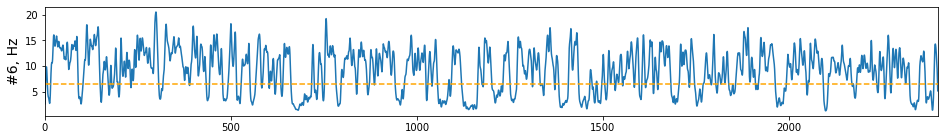

In [611]:
sel_assemblies = [6]
#ass_names = [4]
fig = plt.figure(figsize=(16, 2*len(sel_assemblies)))

for i, ass_id in enumerate(sel_assemblies):
    data = assembly_activity[ass_id]
    
    x_vals = np.arange(len(data))/100
    ax = fig.add_subplot(len(sel_assemblies), 1, i+1)
    ax.plot(x_vals, data)
    ax.set_xlim(0, x_vals.max())
    ax.set_ylabel('#%s, Hz' % ass_id, fontsize=14)
    #ax.set_xlabel('Time, sec', fontsize=14)
    ax.axhline(6.5, ls='--', color='orange')

In [513]:
characteristic_assemblies = {
    '008229_hippoSIT_2022-05-17_21-44-43': [6, 11], # or 5
    '008229_hippoSIT_2022-05-16_20-36-44': [7, 4], # poor
    '008229_hippoSIT_2022-05-20_15-54-39': [11, 10],
    '008229_hippoSIT_2022-05-18_14-36-18': [6, 11]
}

session = '008229_hippoSIT_2022-05-18_14-36-18'
ass_ids = characteristic_assemblies[session]
animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')

In [514]:
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    i_rate1 = np.array(f['assemblies'][str(ass_ids[0])])
    i_rate2 = np.array(f['assemblies'][str(ass_ids[1])])

In [515]:
s_rate = 100 # Hz
i_corrs = np.zeros(240)
for i in range(240):
    idx_l = (i*10)*s_rate
    idx_r = (i*10 + 120)*s_rate # 2 mins window
    i_corrs[i] = pearsonr(i_rate1[idx_l:idx_r], i_rate2[idx_l:idx_r])[0]

Text(0, 0.5, 'Corr. coeff.')

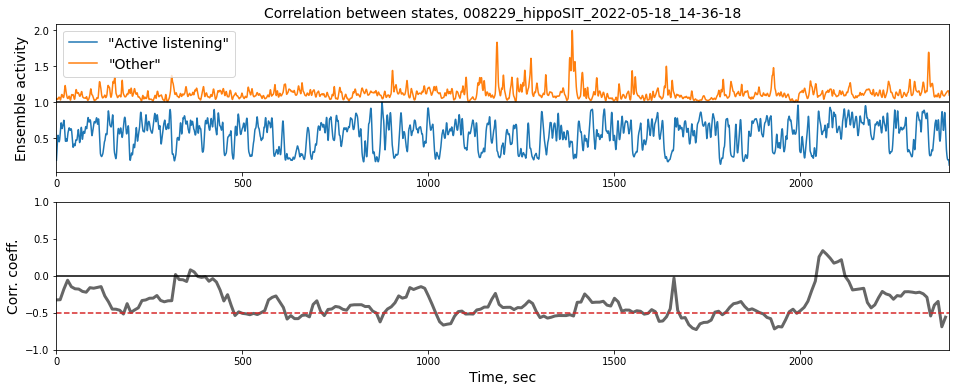

In [516]:
x_vals = tl[(10*np.arange(240)*s_rate).astype(np.int32)][:, 0]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
    
ax1.plot(tl[:, 0], i_rate1/i_rate1.max(), color=COLORS[0], label='"Active listening"')
ax1.plot(tl[:, 0], i_rate2/i_rate2.max() + 1, color=COLORS[1], label='"Other"')
ax2.plot(x_vals, i_corrs, lw=3, color='black', alpha=0.6, label='Corr. coeff.')
    
ax1.set_xlim(0, 240*10)
ax1.axhline(1, color='black')
ax1.legend(fontsize=14, loc='upper left')
ax1.set_title('Correlation between states, %s' % session, fontsize=14)
ax1.set_ylabel('Ensemble activity', fontsize=14)
ax2.axhline(0, color='black')
ax2.set_xlim(0, 240*10)
ax2.set_ylim(-1, 1)
ax2.axhline(-0.5, ls='--', color=COLORS[3])
ax2.set_xlabel('Time, sec', fontsize=14)
ax2.set_ylabel('Corr. coeff.', fontsize=14)